
#    Deep Learning Course 2019
######  Lecturer: Assistant prof. Siamak Mehrkanoon
####  =====================================================================================================

## Assignment-1:

### Download the Iris data and explore it, (visualize it, how many classes, instances, features, etc)
### Select feature number 0 and 2 and the first 100 samples and do the following analysis: 

### 1) Implement the logistic regression model that discussed in the class (with and without regularization). Use Gradient descent algorithm for updating the parameters. Plot the results.

### 2) Explore the influence of learning rate on the convergence of the model. Tune the learning rate.

### 3) Repeat steps 1-4 for different randomly selected features (e.g. 1 and 3 or 2 and 3) and compare the results.

### 4) Give the option to the users to select whatever combination of features they want and your code will do the rest.

### 5)  Try your model on Monk2 dataset and report the results, (test accuracy, training accuracy, optimal learning rate, loss value). Use the last 20% of the data as test.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-deep')

iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
iris.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Iris types count; all are equal to 50 and no missing values in columns

In [2]:
iris.info()
iris[4].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
0    150 non-null float64
1    150 non-null float64
2    150 non-null float64
3    150 non-null float64
4    150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


Iris-setosa        50
Iris-virginica     50
Iris-versicolor    50
Name: 4, dtype: int64

### Target is created 

In [3]:
iris['target'] = iris.apply(lambda x: 0 if x[4] == 'Iris-setosa' else 1 if x[4] == 'Iris-versicolor' else 2, axis=1)
iris.head()
iris.target.value_counts()

2    50
1    50
0    50
Name: target, dtype: int64

### Variable distributions per target

In [4]:
def var_dist(data1, variable1): 
    
    setosa0 = data1[data1.target == 0]
    versicolor0 = data1[data1.target == 1]
    virginica0 = data1[data1.target == 2]
    
    #Variable distributions
    iris_all = data1[variable1]
    max1 = max(iris_all); 
    min1 = min(iris_all); 
    setosa = setosa0[variable1]
    versicolor = versicolor0[variable1]
    virginica = virginica0[variable1]

    bins = np.linspace(min1, max1, 30)

    plt.hist([setosa, versicolor, virginica], bins, label=['setosa_'+str(variable1), 'versicolor_'+str(variable1), 'virginica_'+str(variable1)])
    plt.legend(loc='upper right')
    plt.show()

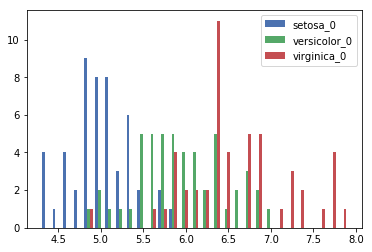

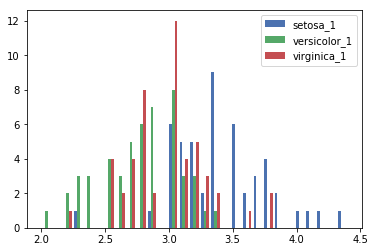

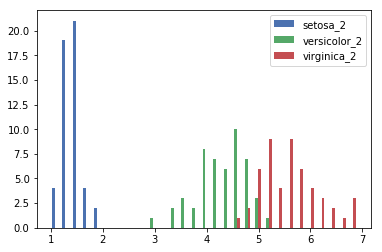

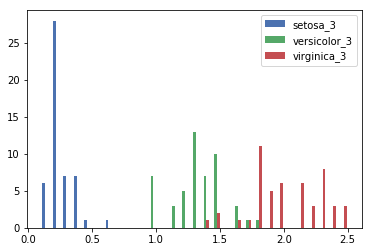

In [5]:
var_dist(iris, 0);
var_dist(iris, 1);
var_dist(iris, 2);
var_dist(iris, 3);

### Functions for Logistic Regression

In [5]:
#sigmoid function
def sigmoid(z):
    return 1/(1 + np.exp(-z))

#predicts probabilities based on theta (variable coefficients/betas) 
def predict(X, theta):
    X_2 = X.loc[:, X.columns != 'prob']
    z = np.dot(X_2, theta)
    h = sigmoid(z)
    X['prob'] = h
    return X

#calculates the loss function wrt log likelihood including L2 regularization
def loss_function(X, y, theta, row1, lambda1):
    theta_2 = np.sum(theta**2)
    return (-y * np.log(X.prob) - (1 - y) * np.log(1 - X.prob)).mean() + (0.5 * lambda1 * theta_2)

#computes gradient in order to update theta including regularization
def gradient(X, y, theta, row1, lambda1):
    X_prob = X.prob
    X_2 = X.loc[:, X.columns != 'prob']
    return (1 / row1) * np.dot(X_2.T, (X_prob - y)) + (lambda1 * theta)

#final classifications from those probabilities
def classify(X, threshold):
    X_prob = X.prob
    X_prediction = X_prob.map(lambda x: 1 if x >= threshold else 0)
    return X_prediction

#evaluation metrics
def metrics(y, X_pred, loss):  
    df = pd.concat([y, X_pred], axis = 1)
    df1 = df.groupby(['target','prob']).size().unstack()
    df1 = df1.fillna(0)
    
    #predicted vs actual values 
    TP = df1.iloc[1][1]; 
    TN = df1.iloc[0][0];
    FN = df1.iloc[1][0];
    FP = df1.iloc[0][1]; 
    #how many observations are correctly classified? 
    accuracy = (TP+TN)/ (TP+TN+FN+FP)
    #among the observations predicted as positive, how many of them actual positive? 
    precision = TP / (TP+FP)
    #how many of them are covered of actual positives?
    recall = TP / (TP+FN)
    
    output = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'loss':loss}  
    return output

### Logistic Regression model

In [17]:
def Log_Reg(data1, var_list, num_iter, learning_rate, lambda1, threshold): 
    #data1 : training data
    #var_list: variables will be used in the model
    #num_iter: number of steps in gradient descent
    #learning_rate: step size
    #lambda1: regularization parameter
    #threshold: cut-off probability for final binary classification
    
    y = data1.target; X = data1[var_list]
    
    #normalization (needed for regularization)
    X_norm = (X-X.mean())/X.std()
    X_norm['bias'] = 1; #all set as 1 for bias term
    X_norm['prob'] = 0; #iteratively updated for final classification
    
    #number of rows and columns, and initialization of betas
    row1, col1 = X_norm.shape
    #initialization of random weights between 0 and 1 
    theta = np.random.uniform(low=0.0, high=1.0, size=(col1-1)) 
    
    #gradient descent iterations
    for i in range(num_iter):
        
        X_norm = predict(X_norm, theta)
        loss = loss_function(X_norm, y, theta, row1, lambda1)
        #print('loss: ', loss)
        grad = gradient(X_norm, y, theta, row1, lambda1)
        theta = theta - (learning_rate * grad)
        
    #classification with final theta
    X_pred = classify(X_norm, threshold)
    
    #model performance
    performance = metrics(y, X_pred, loss)
    
    return X_pred, theta, performance

### Runs

In [18]:
iris_2 = iris.head(100) 
var_list = [0, 2]

#Run 1
#only 50 iterations with learning rate 0.001 and no regularization
X_pred, theta, performance = Log_Reg(iris_2, var_list, 50, 0.001, 0, 0.5);
theta
performance

{'accuracy': 0.83,
 'loss': 0.4627142293248049,
 'precision': 0.7704918032786885,
 'recall': 0.94}

In [19]:
#Run 2
#500 iterations with learning rate 0.001 and no regularization
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.001, 0, 0.5);
theta
performance

{'accuracy': 0.95,
 'loss': 0.28291386942886204,
 'precision': 0.9090909090909091,
 'recall': 1.0}

In [49]:
#Run 3
#500 iterations with learning rate increased to 0.01 and no regularization 
#Improved!
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.01, 0, 0.5);
theta
performance

{'accuracy': 0.97,
 'loss': 0.19759840336066933,
 'precision': 1.0,
 'recall': 0.94}

In [50]:
#Run 4
#1000 iterations with learning rate increased to 0.01 and no regularization
X_pred, theta, performance = Log_Reg(iris_2, var_list, 1000, 0.01, 0, 0.5);
theta
performance

{'accuracy': 0.97,
 'loss': 0.12737359766448203,
 'precision': 1.0,
 'recall': 0.94}

In [51]:
#Run 5
#100 iterations with learning rate increased to 0.05 and no regularization
X_pred, theta, performance = Log_Reg(iris_2, var_list, 100, 0.05, 0, 0.5);
theta
performance

{'accuracy': 0.97,
 'loss': 0.1979577135811128,
 'precision': 1.0,
 'recall': 0.94}

In [52]:
#Run 6
#500 iterations with learning rate increased to 0.05 and no regularization 
#Improved
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.05, 0, 0.5);
theta
performance

{'accuracy': 0.99,
 'loss': 0.0693997475586669,
 'precision': 1.0,
 'recall': 0.98}

In [53]:
#Run 7
#500 iterations with learning rate increased to 0.05 and regularization term as 1
#Worsened (avoid overfitting)
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.05, 1, 0.5);
theta
performance

{'accuracy': 0.96,
 'loss': 0.5657531062474332,
 'precision': 1.0,
 'recall': 0.92}

In [54]:
#Run 8
#500 iterations with learning rate increased to 0.05 and regularization term as 10
#Nothing changed compared to above run
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.05, 10, 0.5);
theta
performance

{'accuracy': 0.96,
 'loss': 0.6757083209107779,
 'precision': 1.0,
 'recall': 0.92}

### Different variable combinations

In [55]:
var_list = [1, 3]

#Run 9
#500 iterations with learning rate increased to 0.05 and regularization term as 1 
#Better than 0 and 2
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.05, 1, 0.5);
theta
performance

{'accuracy': 0.99,
 'loss': 0.5677039846567683,
 'precision': 0.9803921568627451,
 'recall': 1.0}

In [56]:
var_list = [2, 3]

#Run 10
#500 iterations with learning rate increased to 0.05 and regularization term as 1 
#Also, better than 0 and 2
#It can be seen that on its distribution graph, variable 3 looks better than 3 in order to diversify versicolor and virginica
X_pred, theta, performance = Log_Reg(iris_2, var_list, 500, 0.05, 1, 0.5);
theta
performance

{'accuracy': 1.0, 'loss': 0.5373846261036939, 'precision': 1.0, 'recall': 1.0}

### Monk2 dataset 

In [57]:
from mat4py import loadmat
monk2 = loadmat('monk2.mat')
         
monk22 = pd.DataFrame(monk2)       

monk222 = pd.DataFrame(monk22.monk2.tolist(), columns=['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'target'])  

row1, col1 = monk222.shape         

head1 = round(row1*0.8)
    
monk_train = monk222.head(head1)

monk_test = monk222.tail(row1 - head1).reset_index(drop=True)

In [58]:
monk222.head()
monk_test.head()

,var1,var2,var3,var4,var5,var6,target
0,3,3,1,1,3,2,1
1,3,3,1,1,4,1,0
2,3,3,1,2,1,1,0
3,3,3,1,2,1,2,0
4,3,3,1,2,2,1,0


In [59]:
monk222.target.value_counts()

1    228
0    204
Name: target, dtype: int64

In [60]:
monk_train.target.value_counts()

1    202
0    144
Name: target, dtype: int64

In [61]:
monk_test.target.value_counts()
#Target values are not well stratified in train and test set

0    60
1    26
Name: target, dtype: int64

### Evaluation on test data

In [74]:
def evaluate_test(test_data, theta, var_list, threshold, lambda1):
    
    y = test_data.target; X = test_data[var_list]
    row1= X.shape[0]
    
    #normalization (needed for regularization)
    X_norm = (X-X.mean())/X.std()
    X_norm['bias'] = 1;
    X_norm['prob'] = 0;
    
    X_prob = predict(X_norm, theta)
    loss = loss_function(X_prob, y, theta, row1, lambda1) 
    test_prediction = classify(X_prob, threshold)
    test_output = metrics(y, test_prediction, loss)
    
    return test_prediction, test_output

### Training

In [75]:
var_list = ['var1', 'var2', 'var3', 'var4', 'var5', 'var6']  

#Run 1
#No regularization 
X_pred, theta, performance = Log_Reg(monk_train, var_list, 500, 0.01, 0, 0.5)
performance
#Not very good

{'accuracy': 0.8005780346820809,
 'loss': 0.46070337530364114,
 'precision': 0.821256038647343,
 'recall': 0.8415841584158416}

In [76]:
#test performance
#Poorer!
test_prediction, test_output = evaluate_test(monk_test, theta, var_list, 0.5, 0)
test_output

{'accuracy': 0.6511627906976745,
 'loss': 0.5794060093775208,
 'precision': 0.46,
 'recall': 0.8846153846153846}

In [79]:
#Run 2
#number of iteration is increased and regularization term is set as 1
X_pred, theta, performance = Log_Reg(monk_train, var_list, 5000, 0.01, 1, 0.5)
performance

{'accuracy': 0.8092485549132948,
 'loss': 0.6452341961668749,
 'precision': 0.8333333333333334,
 'recall': 0.8415841584158416}

In [80]:
#test performance
#Nothing changed
test_prediction, test_output = evaluate_test(monk_test, theta, var_list, 0.5, 1)
test_output

{'accuracy': 0.6511627906976745,
 'loss': 0.6822382193524424,
 'precision': 0.46,
 'recall': 0.8846153846153846}

In [81]:
#Run 3
#learning rate is increased and no regularization
X_pred, theta, performance = Log_Reg(monk_train, var_list, 1000, 0.05, 0, 0.5)
performance

{'accuracy': 0.7398843930635838,
 'loss': 0.38440971294989135,
 'precision': 0.7641509433962265,
 'recall': 0.801980198019802}

In [82]:
theta

array([ 0.19617738, -1.66361971,  0.02029424, -0.15409807, -1.65338494,
       -0.04356354,  0.61466648])

In [83]:
#test performance
#Nothing changed
test_prediction, test_output = evaluate_test(monk_test, theta, var_list, 0.5, 0)
test_output

{'accuracy': 0.6511627906976745,
 'loss': 0.6330155137860678,
 'precision': 0.46,
 'recall': 0.8846153846153846}

In [84]:
#Run 4
#learning rate is much more increased and no regularization
#Nothing is getting better
X_pred, theta, performance = Log_Reg(monk_train, var_list, 5000, 0.1, 0, 0.5)
performance

{'accuracy': 0.7369942196531792,
 'loss': 0.383717093990302,
 'precision': 0.7630331753554502,
 'recall': 0.7970297029702971}

In [85]:
theta

array([ 0.19447972, -1.79293981,  0.02182256, -0.16848528, -1.78528886,
       -0.0468245 ,  0.6635716 ])

In [86]:
#test performance
#Nothing changed
test_prediction, test_output = evaluate_test(monk_test, theta, var_list, 0.5, 0)
test_output

{'accuracy': 0.6511627906976745,
 'loss': 0.6509081037779897,
 'precision': 0.46,
 'recall': 0.8846153846153846}